In [19]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('./data/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head()

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


In [20]:
print(mercari_df.info(null_counts=True))

/var/folders/wv/bnpq1s_d23qg2x2m69xg48gc0000gn/T/ipykernel_8195/258663560.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  print(mercari_df.info(null_counts=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


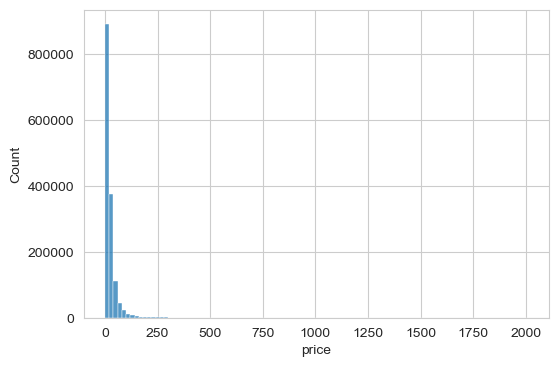

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4 ))
sns.histplot(y_train_df, bins=100)
plt.show()

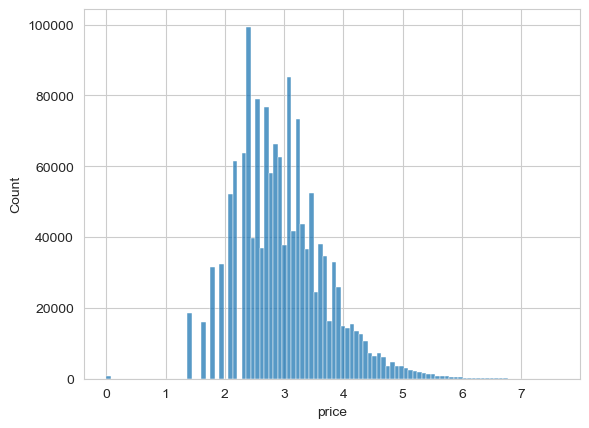

In [22]:
import numpy as np

y_train_df = np.log1p(y_train_df)
sns.histplot(y_train_df, bins=100)
plt.show()

In [23]:
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head()

0    2.397895
1    3.970292
2    2.397895
3    3.583519
4    3.806662
Name: price, dtype: float64

In [24]:
print('Shipping 값 유형 :', mercari_df['shipping'].value_counts())
print('item_condition_id 값 유형 :', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형 : 0    819435
1    663100
Name: shipping, dtype: int64
item_condition_id 값 유형 : 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


In [25]:
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

In [26]:
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']

mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('중분류 개수 :', mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64
중분류 개수 : 114
소분류 개수 : 871


In [27]:
mercari_df['brand_name'] = mercari_df['brand_name'].fillna('Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna('Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna('Other_Null')

mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

In [28]:
print('brand name count :', mercari_df['brand_name'].nunique())
print('brand name sample 5 :', mercari_df['brand_name'].value_counts()[:5])

brand name count : 4810
brand name sample 5 : Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


In [29]:
print('name count :', mercari_df['name'].nunique())
print('name sample :', mercari_df['name'].value_counts()[:7])

name count : 1225273
name sample : Bundle                 2232
Reserved                453
Converse                445
BUNDLE                  418
Dress                   410
Coach purse             404
Lularoe TC leggings     396
Name: name, dtype: int64


In [31]:
pd.set_option('max_colwidth', 200)

print('item_description length mean :', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description length mean : 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

In [32]:
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vector shape :', X_name.shape)
print('descp vector shape :', X_descp.shape)


name vector shape : (1482535, 105757)
descp vector shape : (1482535, 50000)


In [33]:
from sklearn.preprocessing import LabelBinarizer

lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

lb_cat_dae =  LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung =  LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so =  LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])


In [34]:
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape: {}, X_item_cond_id shape: {}, X_shipping shape :{}'.format(X_brand.shape, X_item_cond_id.shape, X_shipping.shape))
print('X_cat_dae shape :{}, X_cat_jung shape :{}, X_cat_so shape :{}'.format(X_cat_dae.shape, X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'> <class 'scipy.sparse._csr.csr_matrix'>
X_brand shape: (1482535, 4810), X_item_cond_id shape: (1482535, 5), X_shipping shape :(1482535, 1)
X_cat_dae shape :(1482535, 11), X_cat_jung shape :(1482535, 114), X_cat_so shape :(1482535, 871)


In [35]:
from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

del X_features_sparse
gc.collect()


<class 'scipy.sparse._csr.csr_matrix'> (1482535, 161569)


12049

In [36]:
def rmsle(y, y_pred):
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)

    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

In [37]:
import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    X = hstack(matrix_list).tocsr()

    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'], test_size=0.2, random_state=156)

    model.fit(X_train, y_train)
    preds = model.predict(X_test)

    del X, X_train, y_train
    gc.collect()

    return preds, y_test

In [38]:
linear_model = Ridge(solver='lsqr', fit_intercept=False)

sparse_matrix_list = (X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print('Item Description 을 제외했을 때 rmsle 값 :', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(linear_model, sparse_matrix_list)
print('Item Description 을 포함했을 때 rmsle 값 :', evaluate_org_price(y_test, linear_preds))

Item Description 을 제외했을 때 rmsle 값 : 0.49844761729693154
Item Description 을 포함했을 때 rmsle 값 : 0.46809373047192987


In [46]:
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_descp, X_name, X_brand, X_item_cond_id, X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(lgbm_model, sparse_matrix_list)
print('LightGBM rmsle값 :', evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle값 : 0.4565268572789318


In [47]:
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM 과 Ridge를 ensemble한 최종 rmsle 값', evaluate_org_price(y_test, preds))

LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.4467133283814073


In [48]:
def my_grid_search(params):
    for weight in params:
        lgbm_weight = weight
        linear_weight = 1 - weight
        preds = lgbm_preds * lgbm_weight + linear_preds * linear_weight
        print(f'\n##### lgbm weight : {lgbm_weight}, linear_weight : {linear_weight}')
        print('LightGBM 과 Ridge를 ensemble한 최종 rmsle 값', evaluate_org_price(y_test, preds))

params = [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]
my_grid_search(params)




##### lgbm weight : 0.3, linear_weight : 0.7
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.4509892646770324

##### lgbm weight : 0.35, linear_weight : 0.65
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.44923702799551546

##### lgbm weight : 0.4, linear_weight : 0.6
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.44781067534781377

##### lgbm weight : 0.45, linear_weight : 0.55
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.4467133283814073

##### lgbm weight : 0.5, linear_weight : 0.5
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.44594741586495745

##### lgbm weight : 0.55, linear_weight : 0.44999999999999996
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.44551464717176253

##### lgbm weight : 0.6, linear_weight : 0.4
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.44541599335613796

##### lgbm weight : 0.65, linear_weight : 0.35
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.4456516763069546

##### lgbm weight : 0.7, linear_weight : 0.30000000000000004
LightGBM 과 Ridge를 ensemble한 최종 rmsle 값 0.44622116625936803
